# Optical Mark Recognition(OMR)

Optical Mark Recognition, or OMR for short, is the process of automatically analyzing human-marked documents and interpreting their results.

In [1]:
# import necessary pakages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib notebook

As a matter of convenience, I have written the entire answer key in plain english here:

 - Question #1: B
 - Question #2: E
 - Question #3: A
 - Question #4: D
 - Question #5: B

In [2]:
# define the answer key which mps th question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

Load the image and preprocess it

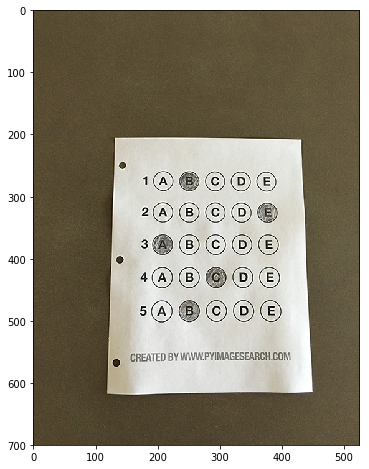

In [3]:
# lets load the image and take a look
image_path = "images\\test_01.png"
image = cv2.imread(image_path)
fig = plt.figure(figsize=(16,8))
plt.imshow(image[...,::-1])
plt.show()


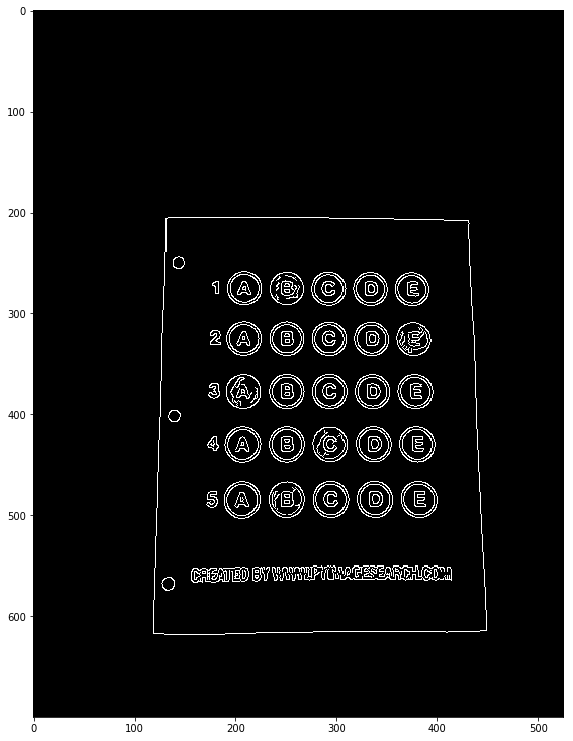

In [4]:
# preprocess the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(src=gray, ksize=(5,5), sigmaX=0)
edged = cv2.Canny(image=blurred, threshold1=75, threshold2=200)
fig = plt.figure(figsize=(13,13))
plt.imshow(edged, cmap='gray')
plt.show()

Notice the clear defined edges of the exam paper. All four vertices of a docuemnt need to be present inorder to perform perspective transform.

Now find contours of the largeset object(the document itself) in the image to apply a perspective transform.

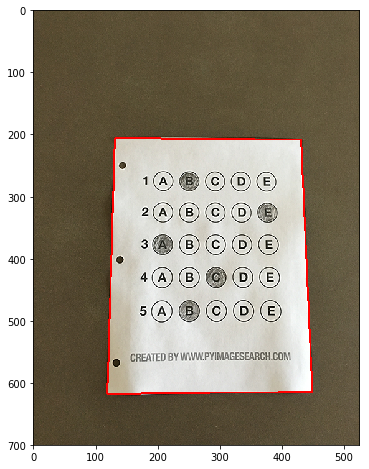

In [5]:
# find contours in the edged image, then initialiize 
# the contour that corresponds to the document
cnts = cv2.findContours(image=edged.copy(), mode=cv2.RETR_EXTERNAL, 
                           method=cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

docCountours = None

# check if countour(s) are found
if len(cnts) > 0:
    # sort the contours according to their size in
    # descending order, keyy top 5 if prsent
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True) [:5]
    
    # loop over the contours
    for c in cnts:
        # approximate the contour
        perimeter = cv2.arcLength(c, closed=True)
        approx = cv2.approxPolyDP(c, epsilon = 0.02*perimeter, closed=True)
        
        # if the approximated contour has four points 
        # then seafely assume that the document has been found
        if len(approx) == 4:
            docCountours= approx

fig = plt.figure(figsize=(11,8))
im = cv2.drawContours(image.copy(), [docCountours], -1, (0,0,255), 2)
plt.imshow(im[...,::-1])
plt.show()

            

After finding the contours we can now apply perspective transform.

the _four_point_transform_  function takes as params:
- image
- Orders the (x, y)-coordinates of our contours in a specific, reproducible manner.

and applies a perspective transform to the region.

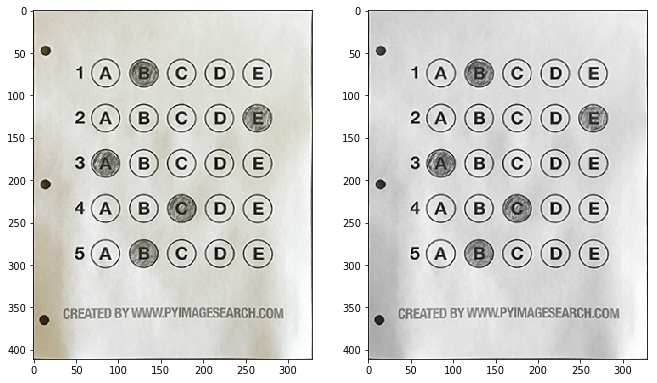

In [6]:
# apply four point perspective trasnformation to both the
# original image and the grayscale image to obtain a
# top-down 'scan' like image 
paper = four_point_transform(image, docCountours.reshape(4,2))
warped = four_point_transform(gray, docCountours.reshape(4,2))
fig, ax = plt.subplots(1,2, figsize=(11,18))
ax[0].imshow(paper[...,::-1]) # perspective transformed original image
ax[1].imshow(warped, cmap='gray') # perspective transformed grayscale image
plt.show()

Now we can move on to finding the choices of the questions

This process starts with binarization of the image.

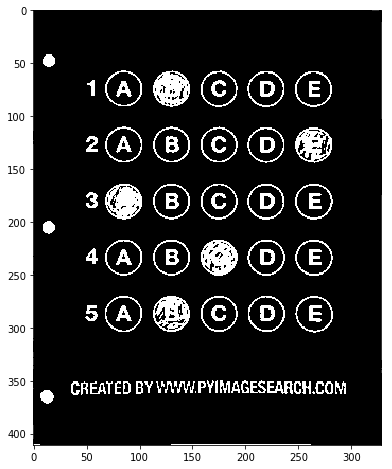

In [7]:
# apply Otsu's thresholding to binarize the waraped image
retVal, thresh = cv2.threshold(src=warped, thresh=0, maxval=255,
                               type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
fig = plt.figure(figsize=(11,8))
plt.imshow(thresh, cmap='gray')
plt.show()

**Notice how the background of the image is black, while the foreground is white.**

This binarization will allow us to once again apply contour extraction techniques to find each of the bubbles in the exam:

In [8]:
# find contours in the thresholded image, then initialize 
# the list of contours that correspod to questions

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionContours = []

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the 
    # bounding box to derive the aspect ratio
    (x,y,w,h) = cv2.boundingRect(c)
    ar = w/float(h) #aspect ratio
    
    # inorder to label the contour as a question, region 
    # should be sufficiently wide, sufficiently tall, and have 
    # an aspect ratio of approximately equal to 1
    if w >=20 and h>=20 and ar >= 0.9 and ar<=1.1:
        questionContours.append(c)

For each of these contours, we compute the bounding box (Line 13 above), which also allows us to compute the aspect ratio, or more simply, the ratio of the width to the height (Line 14 above).

In order for a contour area to be considered a bubble, the region should:
 - Be sufficiently wide and tall (in this case, at least 20 pixels in both dimensions).
 - Have an aspect ratio that is approximately equal to 1.

As long as these checks hold, we can update our _questionCnts_  list and mark the region as a bubble.

Figure below shows the 'bubble' regions found

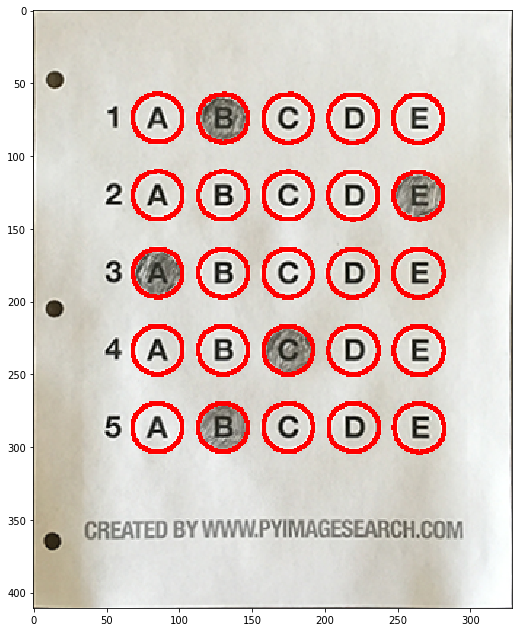

In [9]:
# show the contours of the bubbles
im_copy = paper.copy() # create copy of image to draw on

# for c in questionContours:
#     cv2.drawContours(im_copy, [c], -1, (0,0,255), 2)

cv2.drawContours(im_copy, questionContours, -1, (0,0,255), 2) # draw all at once
# print(im_copy.shape)    
plt.figure(figsize=(11,11)) 
plt.imshow(im_copy[...,::-1])
plt.show()

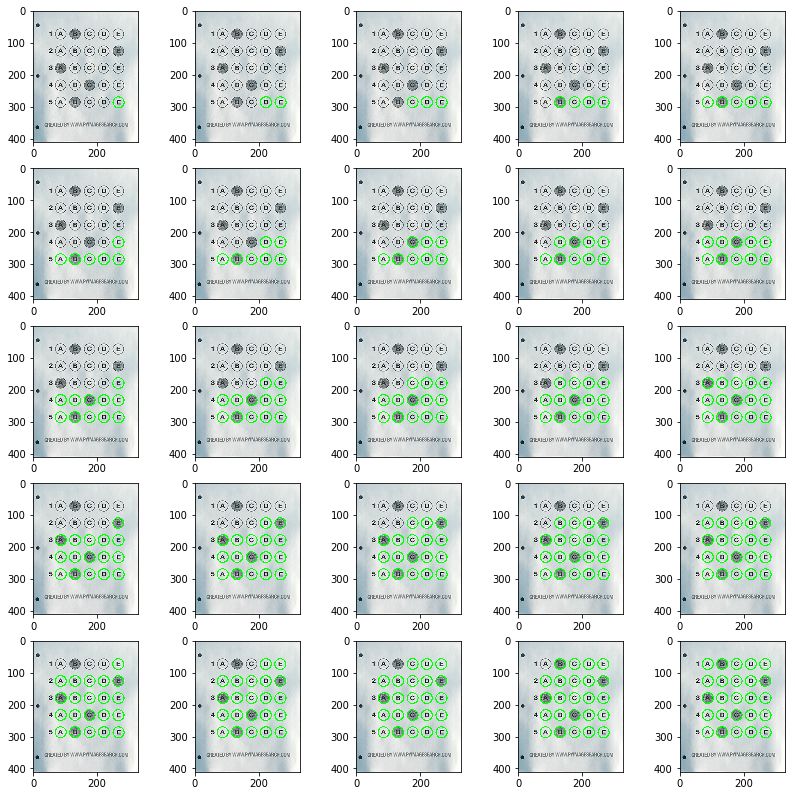

In [10]:
im_copy =paper.copy()
fig, ax = plt.subplots(5,5, figsize=(14,14))
contour_iter = 0
for i in range(5):
    for j in range(5):
        cv2.drawContours(im_copy, [questionContours[contour_iter]],-1,
                        (0,255,0), 2)
        ax[i][j].imshow(im_copy)
        contour_iter+=1
plt.show()

**Note that the contours are stored in a bottom-up and right-to-left manner, we need to change that the countours(bubbles) of the first quesion show come first and in left to right order**


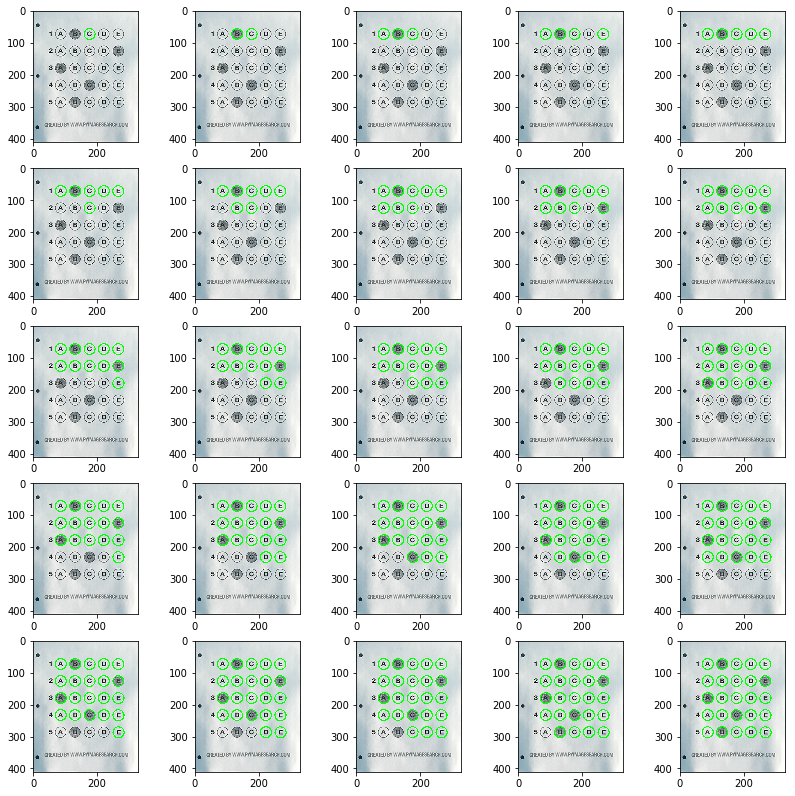

In [11]:
# sort the question contours top-to-bottom, then initialize 
# the total number of correct answers

# questionCountours resturns (countours, boundingboxes)
questionContours = contours.sort_contours(questionContours, 
                                          method="top-to-bottom")[0] # [0]->get the first element

#lets see the output now
im_copy =paper.copy()
fig, ax = plt.subplots(5,5, figsize=(14,14))
contour_iter = 0
for i in range(5):
    for j in range(5):
        cv2.drawContours(im_copy, [questionContours[contour_iter]],-1,
                        (0,255,0), 2)
        ax[i][j].imshow(im_copy)
        contour_iter+=1
plt.show()

**Note that the now the contours are sorted in a 'top-to-bottom' manner but still are not in left-to-right order, we can solve this**

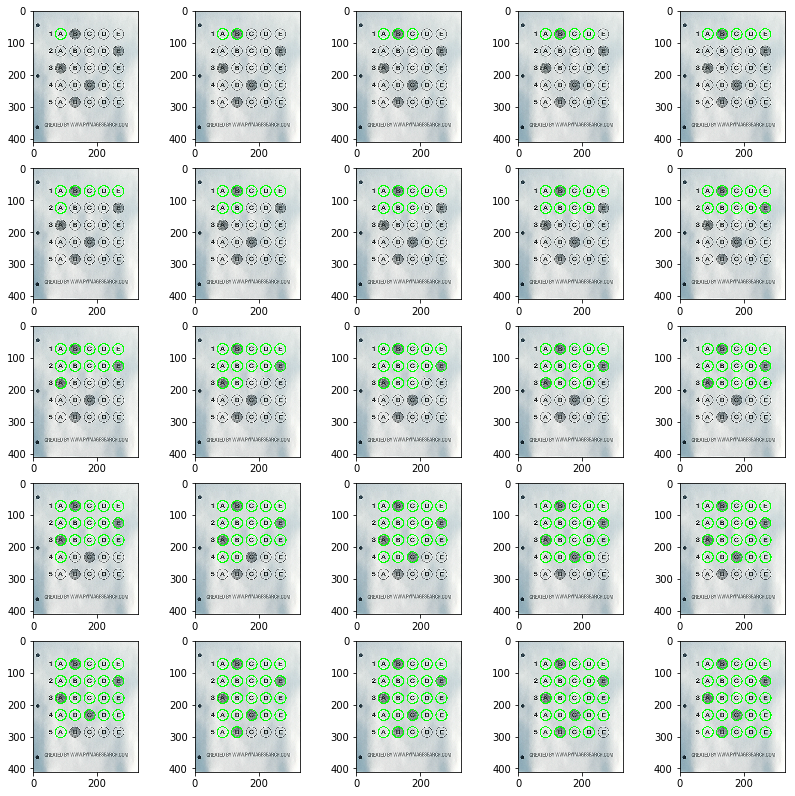

In [14]:
im_copy =paper.copy()
fig, ax = plt.subplots(5,5, figsize=(14,14))
ax_iter =0
# each question has 5 possible answers, loop over the questions in
# batches of 5
for (q, i) in enumerate(np.arange(0, len(questionContours), 5)):
    # sort the contours for the current question from
    # left to right, then initialize the index of the
    # bubbled answer
    cnts = contours.sort_contours(questionContours[i:i+5])[0]
    # lets visualize
    for c in range(len(cnts)):
        cv2.drawContours(im_copy, [cnts[c]],-1,
                        (0,255,0), 2)
        ax[ax_iter][c].imshow(im_copy)
    ax_iter+=1

plt.show()

Very Nice 👌

Now we can move on to the "grading" portion of the OMR system.
Lets put this all together.

Given a row of bubbles, the next step is to determine which bubble is filled in.

We can accomplish this by using our thresh image and counting the number of non-zero pixels (i.e., foreground pixels) in each bubble region:



In [16]:
# sort the question contours top-to-bottom, then initialize 
# the total number of correct answers
questionContours = contours.sort_contours(questionContours, 
                                         method="top-to-bottom")[0] # [0]->get the first element
correct = 0

# each question has 5 possible answers, loop over the questions in
# batches of 5
for (q, i) in enumerate(np.arange(0, len(questionContours), 5)):
    # sort the contours for the current question from
    # left to right, then initialize the index of the
    # bubbled answer
    cnts = contours.sort_contours(questionContours[i:i+5])[0]
    bubbled = None
    
    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current 
        # bubble for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        
        # apply the mask to the thresholded image, then
        # count the  number of non-zero pixels in the 
        # bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)
        
        # if the current total has a larger number of total 
        # non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)
    
    
    # initialize the contour color and the index of the 
    # "correct" answer
    color = (0,0,255) # red
    k = ANSWER_KEY[q]
    
    # check to see if the bubbled-in answer is correct
    if k == bubbled[1]:
        color = (0,255,0) # green
        correct +=1
        
    # draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

Finally, our last code block handles scoring the exam and displaying the results to our screen:

[INFO] score: 80.00%


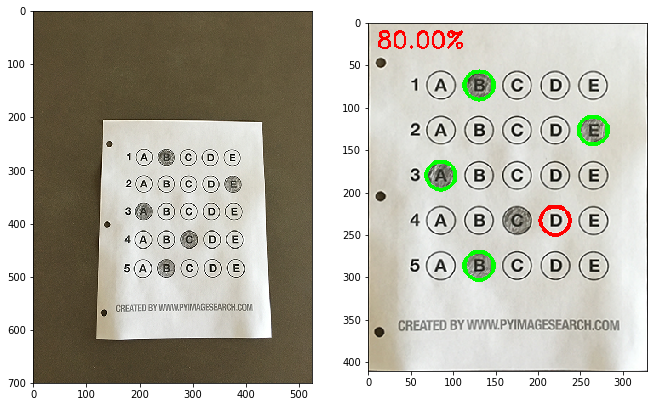

In [17]:
# grab the test taker
score = (correct)/5.0 *100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

fig, ax = plt.subplots(1,2, figsize=(11,18))
ax[0].imshow(image[...,::-1]) 
ax[1].imshow(paper[...,::-1]) 
plt.show()

## Why not use circle detection?

To start, tuning the parameters to _Hough circles_ on an image-to-image basis can be a real pain. But that’s only a minor reason.

The __real reason__ is:

__User error.__

How many times, whether purposely or not, have you filled in outside the lines on your bubble sheet? I’m not expert, but I’d have to guess that at least 1 in every 20 marks a test taker fills in is “slightly” outside the lines.

And guess what?

Hough circles don’t handle deformations in their outlines very well — your circle detection would totally fail in that case.

Because of this, I instead recommend using contours and contour properties to help you filter the bubbles and answers. The cv2.findContours  function doesn’t care if the bubble is “round”, “perfectly round”, or “oh my god, what the hell is that?”.

Instead, the cv2.findContours  function will return a set of blobs to you, which will be the foreground regions in your image. You can then take these regions process and filter them to find your questions (as we did in this tutorial), and go about your way.